In [1]:
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# Configure TensorFlow to use the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')


if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

GPU found
1 Physical GPUs, 1 Logical GPUs


In [2]:
# import os
# import shutil
# import random

# # Define the dataset directory and output directory
# data_dir = r"C:\Users\Administrator\Desktop\EfficientNet\Dataset"
# output_dir = r"C:\Users\Administrator\Desktop\EfficientNet\Random_50_Classes"

# # Create the output directory if it doesn't exist
# os.makedirs(output_dir, exist_ok=True)

# # Get a list of all class folders in the dataset directory
# all_classes = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]

# # Randomly select 50 classes
# selected_classes = random.sample(all_classes, 50)

# # Copy the selected classes to the output directory
# for class_name in selected_classes:
#     src = os.path.join(data_dir, class_name)
#     dest = os.path.join(output_dir, class_name)
#     shutil.copytree(src, dest)

# print(f"Successfully created a dataset with 50 random classes at {output_dir}.")


In [3]:
# import os
# import random
# import shutil

# # Define the dataset directory
# data_dir = r"C:\Users\Administrator\Desktop\EfficientNet\Augmented_Data copy"

# # Function to reduce images in each class to 2000
# def reduce_images(class_dir, target_count=2000):
#     images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
#     current_count = len(images)
    
#     if current_count > target_count:
#         images_to_remove = random.sample(images, current_count - target_count)
#         for img_path in images_to_remove:
#             os.remove(img_path)
#         print(f"Reduced {os.path.basename(class_dir)} from {current_count} to {target_count} images.")
#     else:
#         print(f"Class {os.path.basename(class_dir)} already has {current_count} images.")

# # Reduce images for each class
# for class_name in os.listdir(data_dir):
#     class_dir = os.path.join(data_dir, class_name)
#     if os.path.isdir(class_dir):
#         reduce_images(class_dir)

# print(f"Successfully reduced images to 2000 per class in {data_dir}.")

In [2]:
import cv2
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from transformers import AutoImageProcessor, TFViTModel
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense,Flatten


# Load the dataset directory path
# data_dir = "M:/Datasets/aloi_ill/png"  # Update this to your dataset path
data_dir = r"M:\SIFT\small_data"  # Update this to your dataset path
data_dir = r"C:\Users\Administrator\Desktop\EfficientNet\SIFT\small_data"  # Update this to your dataset path
data_dir = r"C:\Users\Administrator\Desktop\EfficientNet\Augmented_Data copy"  # Update this to your dataset path

image_paths = []
labels = []

# Load images and assign labels based on folder names
for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        for file in os.listdir(class_dir):
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, file))
                labels.append(int(label))  # Convert folder name to integer label



print(image_paths)
print(len(labels))

print(len(image_paths))

# show number of classes and images per class in the dataset
unique_labels = set(labels)
print(f"Number of classes: {len(unique_labels)}")   
print("Number of images per class:")
for label in unique_labels:
    print(f"Class {label}: {labels.count(label)} images")




c:\Users\Administrator\anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1.jpeg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1005.jpeg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1014.jpeg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1016.jpeg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_102.jpeg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1022.jpeg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1024.jpeg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1036.jpeg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1040.jpeg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1046.jpeg', 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11

In [5]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# import os
# import numpy as np

# # Define the dataset directory and output directory
# data_dir = r"C:\Users\Administrator\Desktop\EfficientNet\Random_50_Classes"
# output_dir = r"C:\Users\Administrator\Desktop\EfficientNet\Augmented_Data_copy"

# # Create the output directory if it doesn't exist
# if os.path.exists(output_dir):
#     shutil.rmtree(output_dir)
# os.makedirs(output_dir)

# # Initialize the ImageDataGenerator for augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Function to augment images
# def augment_images(class_dir, output_class_dir, target_count=1500):
#     images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
#     current_count = len(images)
    
#     if current_count >= target_count:
#         print(f"Class {os.path.basename(class_dir)} already has {current_count} images.")
#         return
    
#     for img_path in images:
#         img = load_img(img_path)
#         x = img_to_array(img)
#         x = np.expand_dims(x, axis=0)
        
#         # Generate augmented images
#         i = 0
#         for batch in datagen.flow(x, batch_size=1, save_to_dir=output_class_dir, save_prefix='aug', save_format='jpeg'):
#             i += 1
#             if current_count + i >= target_count:
#                 break

# # Augment images for each class
# for class_name in os.listdir(data_dir):
#     class_dir = os.path.join(data_dir, class_name)
#     output_class_dir = os.path.join(output_dir, class_name)
#     os.makedirs(output_class_dir, exist_ok=True)
#     augment_images(class_dir, output_class_dir)

# print(f"Successfully augmented images to 1500 per class in {output_dir}.")

In [3]:
# Step 1: Load EfficientNet model
base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
# model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
base_model.trainable = False
# print(base_model.summary())
inputs=Input(shape=(3,224, 224), name='pixel_values', dtype='float32')
output=base_model(inputs).last_hidden_state
model = Model(inputs=inputs,outputs=output)


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [6]:
image_paths

['C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1.jpeg',
 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1005.jpeg',
 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1014.jpeg',
 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1016.jpeg',
 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_102.jpeg',
 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1022.jpeg',
 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1024.jpeg',
 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1036.jpeg',
 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1040.jpeg',
 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy\\11\\aug_0_1046.jpeg',
 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Dat

In [4]:

img1= cv2.imread(image_paths[0])
img1 = cv2.resize(img1, (224, 224))  # Resize to EfficientNet input size
img1 = np.transpose(img1, (2, 0, 1))  # Transpose the image to shape (3, 224, 224)
img1 = preprocess_input(img1)  # Preprocess the image
img1 = np.expand_dims(img1, axis=0)  # Add batch dimension



In [5]:
feature = model(img1)  # Extract features
feature = Flatten()(feature)
print(feature.shape)

(1, 151296)


In [8]:
def extract_features(image_paths, batch_size=64, output_dir="features"):
    import os
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        
        for image_path in batch_paths:
            print(f"Processing: {image_path}")
            img = cv2.imread(image_path)
            img = cv2.resize(img, (224, 224))  # Resize to EfficientNet input size
            #    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 3, 224, 224), found shape=(64, 224, 224, 3)
            img = np.transpose(img, (2, 0, 1))
            img = preprocess_input(img)  # Preprocess for EfficientNet
            batch_images.append(img)
        
        batch_images = np.array(batch_images)  # Create a batch
        batch_features = model.predict(batch_images, batch_size=batch_size)  # Extract features
        
        # Save batch features to disk
        batch_file = os.path.join(output_dir, f"batch_{i//batch_size}.npy")
        np.save(batch_file, batch_features)
        print(f"Saved features for batch {i//batch_size} to {batch_file}")

    print(f"Features saved to directory: {output_dir}")

# # Extract features for all images
extract_features(image_paths,output_dir="small_data_features")
# extract_features(image_paths)
#adjust combined features to 2D




Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_Data copy\11\aug_0_1.jpeg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_Data copy\11\aug_0_1005.jpeg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_Data copy\11\aug_0_1014.jpeg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_Data copy\11\aug_0_1016.jpeg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_Data copy\11\aug_0_102.jpeg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_Data copy\11\aug_0_1022.jpeg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_Data copy\11\aug_0_1024.jpeg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_Data copy\11\aug_0_1036.jpeg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_Data copy\11\aug_0_1040.jpeg
Processing: C:\Users\Administrator\Desktop\EfficientNet\Augmented_Data copy\11\aug_0_1046.jpeg
Processing: C:\Users\Administrator\Desktop\EfficientNe

In [ ]:
# import os
# import glob

# # Define the base directory
# base_dir = 'C:\\Users\\Administrator\\Desktop\\EfficientNet\\Augmented_Data copy'

# # Iterate through each class folder
# for class_folder in os.listdir(base_dir):
#     class_path = os.path.join(base_dir, class_folder)
#     if os.path.isdir(class_path):
#         # Get all image files in the folder
#         image_files = glob.glob(os.path.join(class_path, '*'))
        
#         # Check if there are more than 500 images
#         if len(image_files) > 500:
#             # Sort the files to ensure consistent deletion
#             image_files.sort()
            
#             # Delete the excess images
#             for image_file in image_files[500:]:
#                 os.remove(image_file)
#                 print(f"Deleted: {image_file}")

In [10]:
#use features from the saved files
labels = np.array(labels)
def load_features(feature_dir):
    features = []
    for file in os.listdir(feature_dir):
        print(file)
        batch_file = os.path.join(feature_dir, file)
        batch_features = np.load(batch_file)
        # batch_features = Flatten()(batch_features)
        features.append(batch_features)
    return np.vstack(features)

# Load features from disk
feature_dir = "small_data_features"
# feature_dir = "features"
combined_features = load_features(feature_dir)


batch_0.npy
batch_1.npy
batch_10.npy
batch_100.npy
batch_101.npy
batch_102.npy
batch_103.npy
batch_104.npy
batch_105.npy
batch_106.npy
batch_107.npy
batch_108.npy
batch_109.npy
batch_11.npy
batch_110.npy
batch_111.npy
batch_112.npy
batch_113.npy
batch_114.npy
batch_115.npy
batch_116.npy
batch_117.npy
batch_118.npy
batch_119.npy
batch_12.npy
batch_120.npy
batch_121.npy
batch_122.npy
batch_123.npy
batch_124.npy
batch_125.npy
batch_126.npy
batch_127.npy
batch_128.npy
batch_129.npy
batch_13.npy
batch_130.npy
batch_131.npy
batch_132.npy
batch_133.npy
batch_134.npy
batch_135.npy
batch_136.npy
batch_137.npy
batch_138.npy
batch_139.npy
batch_14.npy
batch_140.npy
batch_141.npy
batch_142.npy
batch_143.npy
batch_144.npy
batch_145.npy
batch_146.npy
batch_147.npy
batch_148.npy
batch_149.npy
batch_15.npy
batch_150.npy
batch_151.npy
batch_152.npy
batch_153.npy
batch_154.npy
batch_155.npy
batch_156.npy
batch_16.npy
batch_17.npy
batch_18.npy
batch_19.npy
batch_2.npy
batch_20.npy
batch_21.npy
batch_22.n

In [11]:
#print the shape of the features
print(combined_features.shape)

(10000, 197, 768)


In [12]:
#flatten the features
combined_features = combined_features.reshape(combined_features.shape[0], -1)

In [13]:
combined_features = np.squeeze(combined_features)

In [14]:
combined_features.shape, labels.shape

((10000, 151296), (10000,))

In [15]:
# Step 3: Train and test classifier
# Ensure combined_features and labels have the same length
min_length = min(len(combined_features), len(labels))
combined_features = combined_features[:min_length]
labels = labels[:min_length]

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(combined_features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


In [16]:
print(X_train[0])
print(y_train[0])

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

[-0.02973348 -0.12612621  0.00294761 ... -0.32849365  0.06961129
 -0.01683349]
283
(7000, 151296)
(1500, 151296)
(7000,)
(1500,)


In [20]:
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensionality
pca = PCA(n_components=1000)  # You can adjust the number of components as needed
reduced_features = pca.fit_transform(combined_features)

print("Original shape:", combined_features.shape)
print("Reduced shape:", reduced_features.shape)

Original shape: (10000, 151296)
Reduced shape: (10000, 1000)


In [17]:
import numpy as np

# Count frequency of numbers in y_train
unique_train, counts_train = np.unique(y_train, return_counts=True)
frequency_train = dict(zip(unique_train, counts_train))

# Count frequency of numbers in y_test
unique_test, counts_test = np.unique(y_test, return_counts=True)
frequency_test = dict(zip(unique_test, counts_test))

print("Frequency in y_train:", frequency_train)
print("Frequency in y_test:", frequency_test)

Frequency in y_train: {2: 339, 11: 331, 18: 365, 19: 367, 121: 351, 157: 335, 164: 357, 172: 347, 188: 330, 198: 341, 207: 352, 218: 358, 229: 352, 245: 356, 247: 351, 249: 357, 257: 343, 271: 333, 283: 364, 286: 371}
Frequency in y_test: {2: 77, 11: 90, 18: 78, 19: 74, 121: 70, 157: 63, 164: 78, 172: 76, 188: 85, 198: 76, 207: 71, 218: 71, 229: 70, 245: 75, 247: 71, 249: 74, 257: 80, 271: 87, 283: 59, 286: 75}


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reshape the data to fit LSTM input requirements
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Convert labels to categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)


In [19]:

# Build the model
model_lstm = Sequential([
    LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(y_train_cat.shape[1], activation='softmax')
])
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [20]:

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)


In [21]:

history = model_lstm.fit(X_train_lstm, y_train_cat, epochs=1000, batch_size=32, validation_data=(X_val_lstm, y_val_cat), verbose=1)





Epoch 1/1000
219/219 [==============================] - 6s 14ms/step - loss: 3.6959 - accuracy: 0.0917 - val_loss: 3.0876 - val_accuracy: 0.0760
Epoch 2/1000
219/219 [==============================] - 2s 10ms/step - loss: 3.0077 - accuracy: 0.1381 - val_loss: 2.9677 - val_accuracy: 0.1433
Epoch 3/1000
219/219 [==============================] - 2s 10ms/step - loss: 2.9233 - accuracy: 0.1616 - val_loss: 2.9071 - val_accuracy: 0.1333
Epoch 4/1000
219/219 [==============================] - 2s 10ms/step - loss: 2.8740 - accuracy: 0.1623 - val_loss: 2.8592 - val_accuracy: 0.1433
Epoch 5/1000
219/219 [==============================] - 2s 10ms/step - loss: 2.8349 - accuracy: 0.1576 - val_loss: 2.8336 - val_accuracy: 0.1527
Epoch 6/1000
219/219 [==============================] - 2s 10ms/step - loss: 2.7996 - accuracy: 0.1664 - val_loss: 2.7971 - val_accuracy: 0.1487
Epoch 7/1000
219/219 [==============================] - 2s 10ms/step - loss: 2.7691 - accuracy: 0.1653 - val_loss: 2.7772 - val_ac

KeyboardInterrupt: 

In [26]:
history.history.keys()
print(history.history.keys())
print(history.history['accuracy'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.1525714248418808, 0.27071428298950195, 0.27085715532302856, 0.3087143003940582, 0.32171428203582764, 0.3240000009536743, 0.3257142901420593, 0.33314284682273865, 0.329714298248291, 0.33228570222854614, 0.3051428496837616, 0.2978571355342865, 0.2962857186794281, 0.3051428496837616, 0.2995714247226715, 0.30971428751945496, 0.3198571503162384, 0.2944285571575165, 0.30557143688201904, 0.3035714328289032, 0.3172857165336609, 0.329714298248291, 0.3337142765522003, 0.35171428322792053, 0.35357141494750977, 0.347428560256958, 0.35499998927116394, 0.3537142872810364, 0.35271430015563965, 0.3578571379184723, 0.3529999852180481, 0.3498571515083313, 0.35757142305374146, 0.363571435213089, 0.36328572034835815, 0.3588571548461914, 0.3677142858505249, 0.3634285628795624, 0.36399999260902405, 0.3678571283817291, 0.36800000071525574, 0.36885714530944824, 0.36585715413093567, 0.37042856216430664, 0.3720000088214874, 0.37128570675849915, 0.36

In [27]:
# Assuming you want to print the test accuracy

# Evaluate the model on the test set
loss, accuracy = model_lstm.evaluate(X_test_lstm, y_test_cat, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Test Loss: 1.6889
Test Accuracy: 0.4107


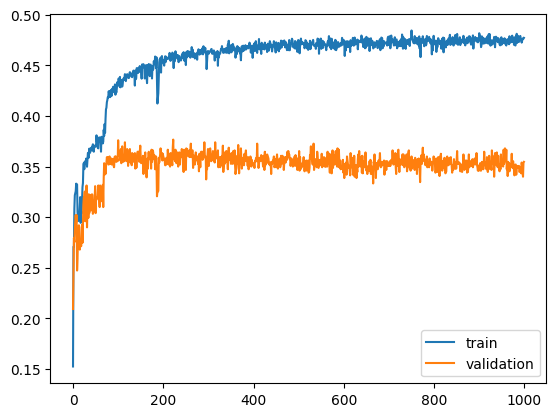

In [28]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()